In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [15]:
def before2018(df):
    mask = (df['Date'] >= '01/01/2000') & (df['Date'] < '01/01/2018')
    return df.loc[mask]

In [16]:
def buildDataFrameCleaned(df):
    df_cleaned = df[df.Hora != 0]
    df_leftover = df[df.Hora == 0]
    df_cleaned = df_cleaned[["Estacao", "Data", "Precipitacao"]]
    df_cleaned['Date'] = df_cleaned['Data'].astype('str')
    df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%d/%m/%Y', errors='coerce')
    df_cleaned['year'] = df_cleaned.Date.dt.year
    df_cleaned['month'] = df_cleaned.Date.dt.month
    df_cleaned['day'] = df_cleaned.Date.dt.day
    df_cleaned["Precipitacao"].fillna(0, inplace=True)
    return before2018(df_cleaned)

In [17]:
def setLongLat(df, lat, long):
    df["long"] = long
    df["lat"] = lat

## Carregando dados dos arquivos para dataframes

In [18]:
dataset_recife = pd.read_csv('original_data/Recife(curado).txt', delimiter=';')
dataset_arcoverde = pd.read_csv('original_data/arcoverde.txt', delimiter=';')
dataset_cabrobo = pd.read_csv('original_data/cabrobo.txt', delimiter=';')
dataset_ouricuri = pd.read_csv('original_data/ouricuri.txt', delimiter=';')
dataset_petrolina = pd.read_csv('original_data/petrolina.txt', delimiter=';')
dataset_surubim = pd.read_csv('original_data/surubim.txt', delimiter=';')
dataset_triunfo = pd.read_csv('original_data/triunfo.txt', delimiter=';')

## Limpando os dataframes 

In [19]:
df_recife_cleaned = buildDataFrameCleaned(dataset_recife)
df_arcoverde_cleaned = buildDataFrameCleaned(dataset_arcoverde)
df_cabrobo_cleaned = buildDataFrameCleaned(dataset_cabrobo)
df_ouricuri_cleaned = buildDataFrameCleaned(dataset_ouricuri)
df_petrolina_cleaned = buildDataFrameCleaned(dataset_petrolina)
df_surubim_cleaned = buildDataFrameCleaned(dataset_surubim)
df_triunfo_cleaned = buildDataFrameCleaned(dataset_triunfo)

## Inserindo as latitudes e longitudes para cada cidade

In [20]:
setLongLat(df_recife_cleaned, -8.05, -34.95)
setLongLat(df_arcoverde_cleaned, -8.41, -37.08)
setLongLat(df_cabrobo_cleaned, -8.51, -39.33)
setLongLat(df_ouricuri_cleaned, -7.9, -40.04)
setLongLat(df_petrolina_cleaned, -9.36, -40.46)
setLongLat(df_surubim_cleaned, -7.83, -35.71)
setLongLat(df_triunfo_cleaned, -7.81, -38.11)

## Concatenando os dataframes e nomeando as cidades

In [21]:
concat_cities = pd.concat(
        [df_recife_cleaned, df_arcoverde_cleaned, df_cabrobo_cleaned, df_ouricuri_cleaned, df_petrolina_cleaned,
         df_surubim_cleaned, df_triunfo_cleaned])
concat_cities = concat_cities.replace({'Estacao': {82900: 'RECIFE', 82890: 'ARCOVERDE', 82886: 'CABROBÓ',
                                                       82753: 'OURICURI', 82983: 'PETROLINA', 82797: 'SURUBIM',
                                                       82789: 'TRIUNFO'}})

## Criando dataframe apenas com Escações, latitude e longitude

In [22]:
df_drop_duplicates = concat_cities.drop_duplicates("Estacao")
df_long_lat = df_drop_duplicates[["Estacao", "long", "lat"]]

## Criando dataframe com agrupamento do somatório de precipitações por mês

In [23]:
df_precipitation_grouby_year_month = pd.DataFrame({
        'Precipitacao': concat_cities.groupby(["Estacao", "year", "month"])["Precipitacao"].sum()}).reset_index()

result_monthly_precipitation_sum = pd.merge(df_precipitation_grouby_year_month, df_long_lat, on='Estacao')

## Salvando os dados de precipitações diárias e mensais 

In [24]:
result_monthly_precipitation_sum.to_csv("filtered_data/result_monthly_precipitation_sum.csv", sep=',', encoding='utf-8')
concat_cities.to_csv("filtered_data/all_cities.csv", sep=',', encoding='utf-8')

## BoxPlot dos dados diários de 2000 até 2017

[Text(0, 0.5, 'Precipitação mensal'),
 Text(0.5, 0, 'Anos'),
 Text(0.5, 1.0, 'Distribuição da precipitação anual por cidade')]

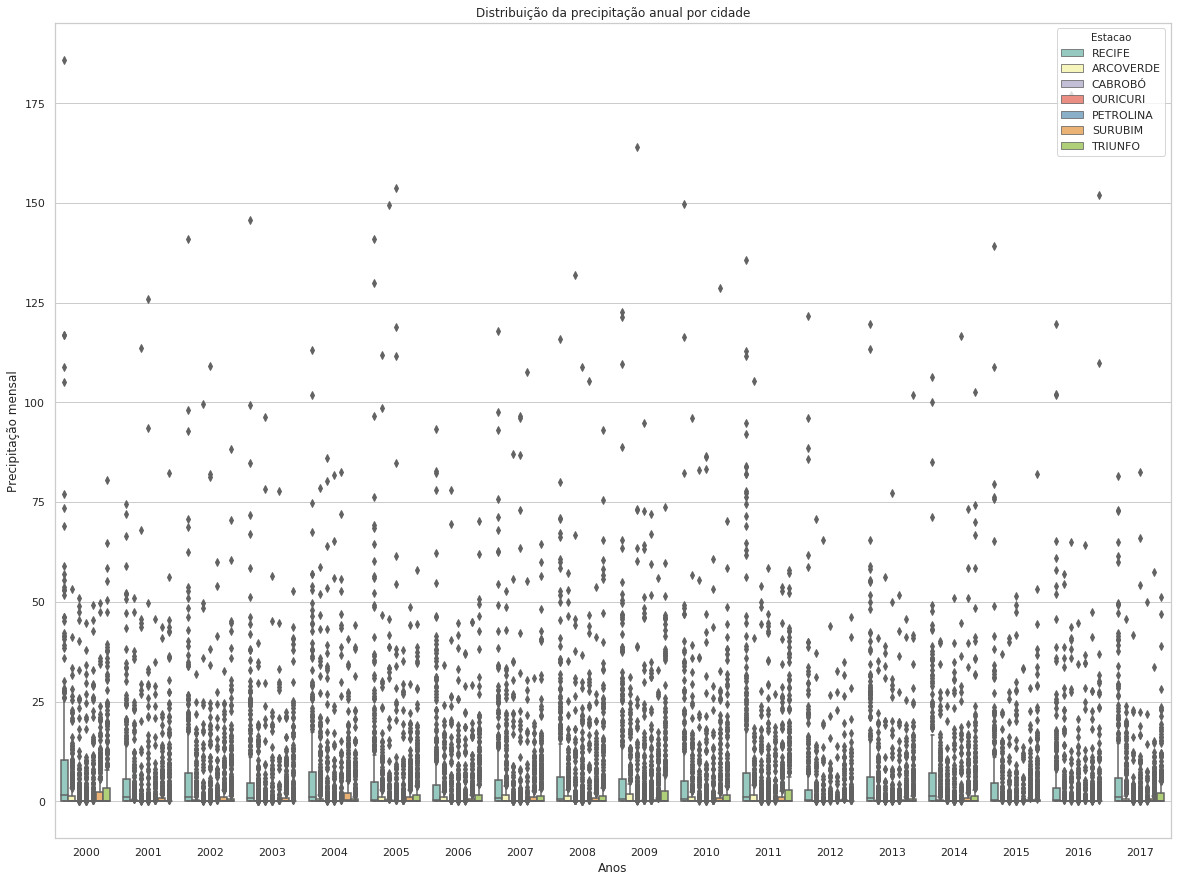

In [27]:
plt.subplots(figsize=(20,15))
ax = sns.boxplot(x="year", y="Precipitacao", hue="Estacao", data=concat_cities, palette="Set3")
ax.set(xlabel='Anos', ylabel= u'Precipitação mensal', title=u'Distribuição da precipitação anual por cidade')

## BoxPlot dos dados da soma da precipitação mensal de 2000 - 2017

[Text(0, 0.5, 'Precipitação mensal'),
 Text(0.5, 0, 'Anos'),
 Text(0.5, 1.0, 'Distribuição mensal da precipitação anual por cidade')]

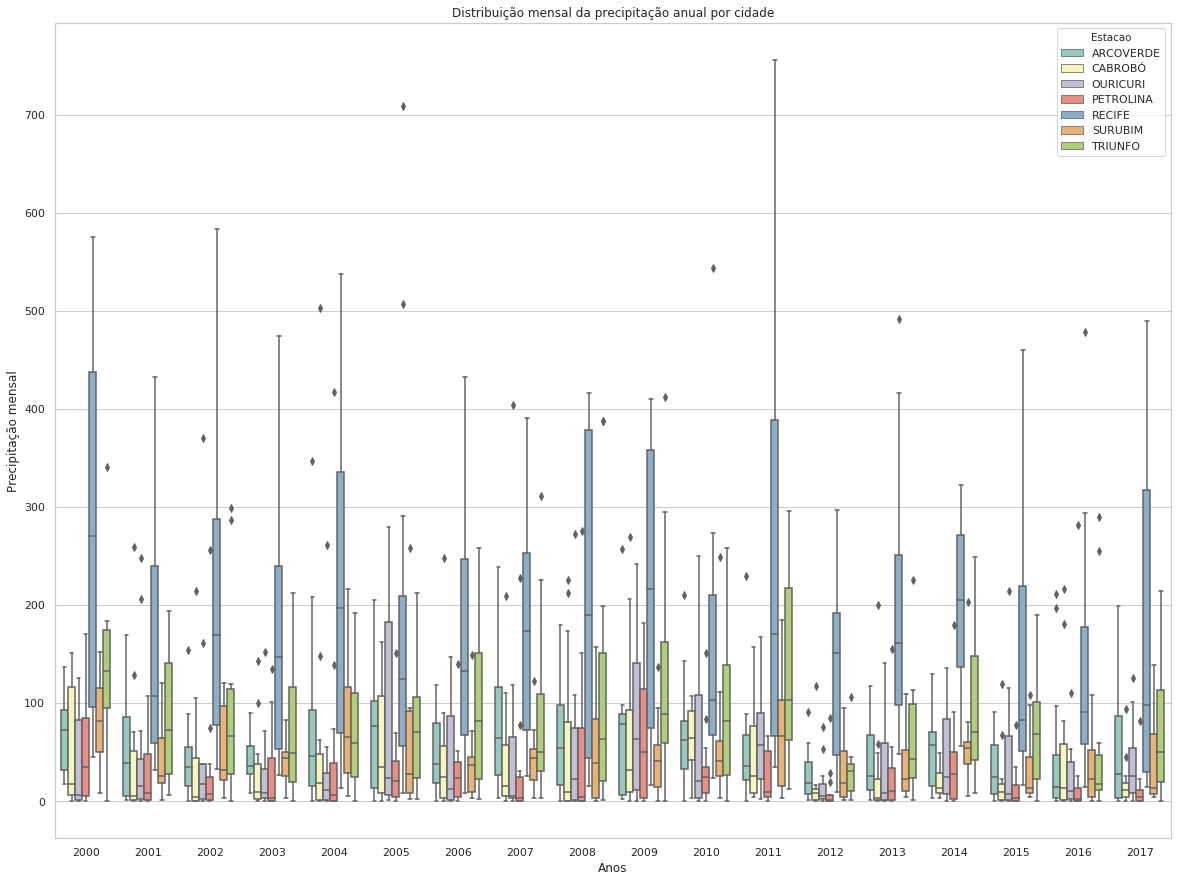

In [30]:
plt.subplots(figsize=(20,15))
ax = sns.boxplot(x="year", y="Precipitacao", hue="Estacao", data=result_monthly_precipitation_sum, palette="Set3")
ax.set(xlabel='Anos', ylabel= u'Precipitação mensal', title=u'Distribuição mensal da precipitação anual por cidade')

## Barplot da soma da pricipitação anual de 2000 - 2017

[Text(0, 0.5, 'Precipitação anual'),
 Text(0.5, 0, 'Anos'),
 Text(0.5, 1.0, 'Soma da precipitação por cidade')]

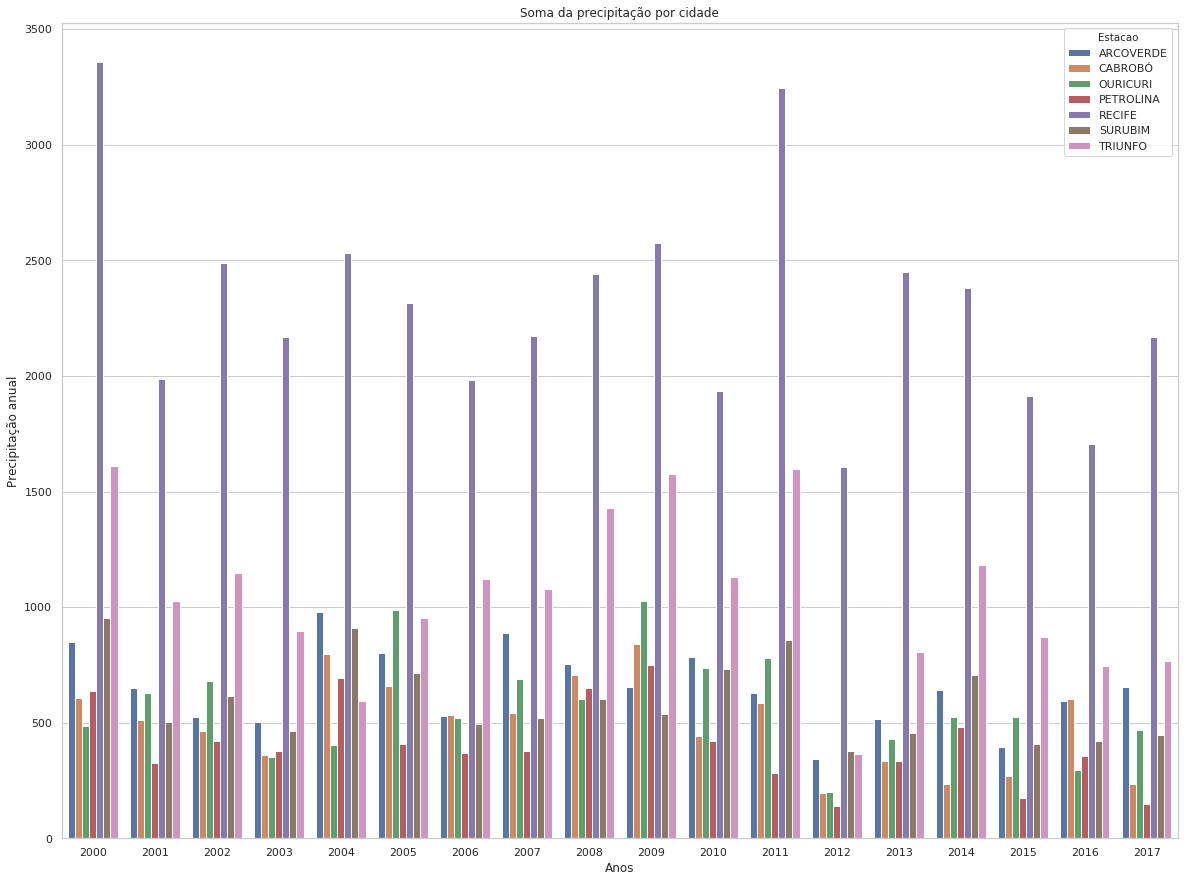

In [42]:
df_precipitation_sum = pd.DataFrame({'annual_precipitation_sum' : result_monthly_precipitation_sum.groupby(["Estacao", "year"])["Precipitacao"].sum()}).reset_index()
sns.set(style="whitegrid")
plt.subplots(figsize=(20,15))
ax = sns.barplot(x="year", y="annual_precipitation_sum", hue="Estacao", data=df_precipitation_sum)
ax.set(xlabel='Anos', ylabel= u'Precipitação anual', title=u'Soma da precipitação por cidade')

## Barplot da média da precipitação anual 

[Text(0, 0.5, 'Média'),
 Text(0.5, 0, 'Anos'),
 Text(0.5, 1.0, 'Média da precipitação anual')]

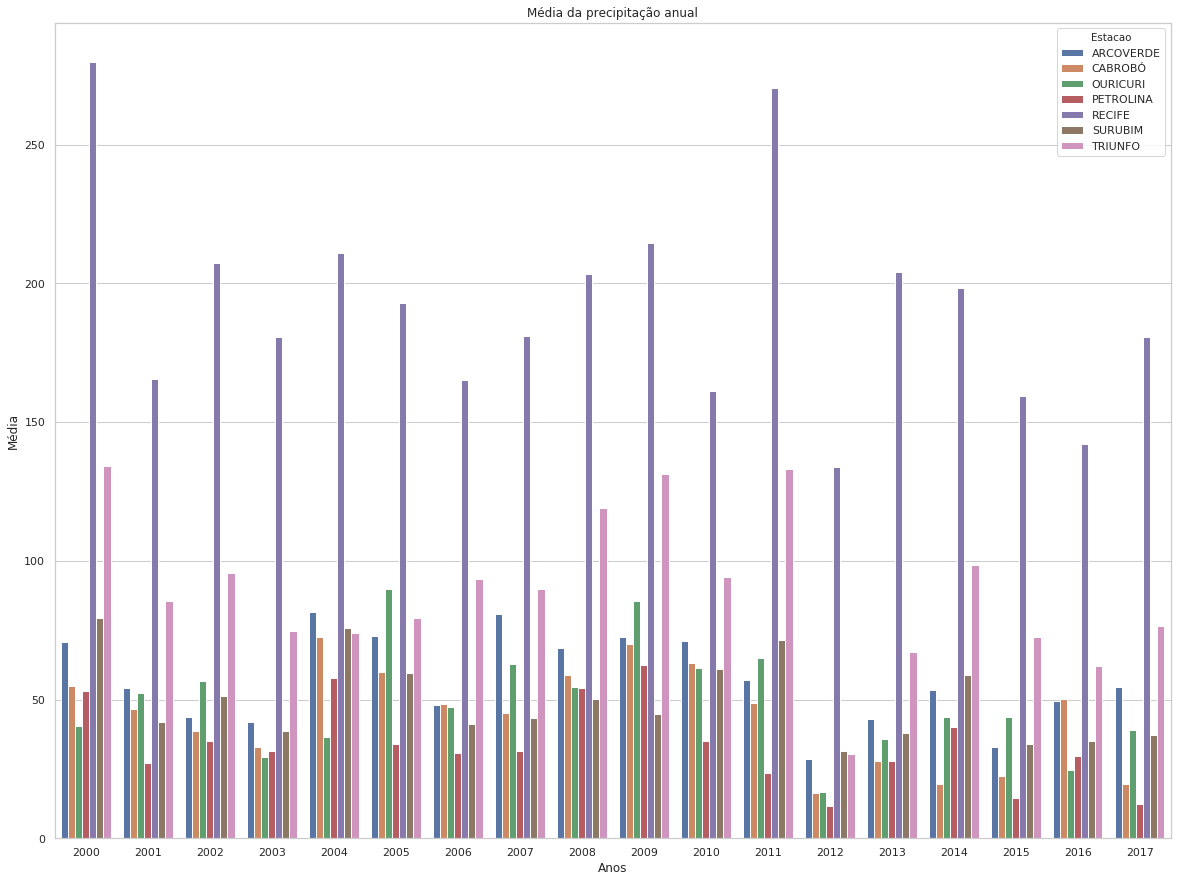

In [43]:
df_precipitation_annual_average = pd.DataFrame({'precipitation_annual_average' : result_monthly_precipitation_sum.groupby(["Estacao", "year"])["Precipitacao"].mean()}).reset_index()
sns.set(style="whitegrid")
plt.subplots(figsize=(20,15))
ax = sns.barplot(x="year", y="precipitation_annual_average", hue="Estacao", data=df_precipitation_annual_average)
ax.set(xlabel='Anos', ylabel= u'Média', title=u'Média da precipitação anual')

In [45]:
result_monthly_precipitation_sum.head()

,Estacao,year,month,Precipitacao,long,lat
0,ARCOVERDE,2000,1,43.3,-37.08,-8.41
1,ARCOVERDE,2000,2,83.5,-37.08,-8.41
2,ARCOVERDE,2000,3,70.2,-37.08,-8.41
3,ARCOVERDE,2000,4,135.9,-37.08,-8.41
4,ARCOVERDE,2000,5,27.6,-37.08,-8.41


## Barplot da precipitação mensal em Recife - 2011

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Meses'),
 Text(0.5, 1.0, 'Precipitação mensal em Recife - 2011')]

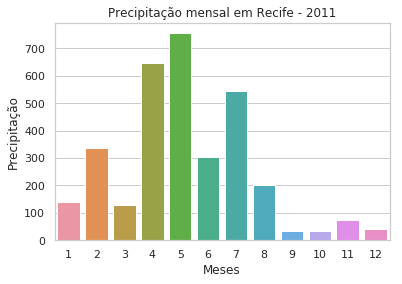

In [50]:
df_month_precipitation_2011 = result_monthly_precipitation_sum[result_monthly_precipitation_sum['year'] == 2011]
df_month_precipitation_2011 = df_month_precipitation_2011[df_month_precipitation_2011['Estacao'] == 'RECIFE']
sns.set(style="whitegrid")
ax = sns.barplot(x="month", y="Precipitacao", data=df_month_precipitation_2011)
ax.set(xlabel='Meses', ylabel= u'Precipitação', title=u'Precipitação mensal em Recife - 2011')


## Boxplot da precipitação diária em Recife - 2011 

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Meses'),
 Text(0.5, 1.0, 'Distribuição diária da precipitação em Recife - 2011')]

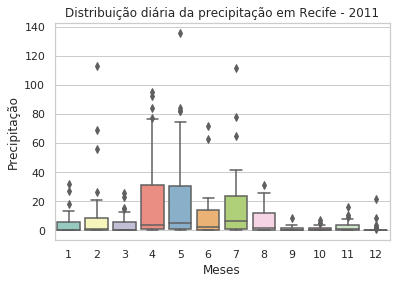

In [52]:
df_day_precipitation_2011 = concat_cities[concat_cities['year'] == 2011]
df_day_precipitation_2011 = df_day_precipitation_2011[df_day_precipitation_2011['Estacao'] == 'RECIFE']
ax = sns.boxplot(x="month", y="Precipitacao", data= df_day_precipitation_2011, palette="Set3")
ax.set(xlabel='Meses', ylabel= u'Precipitação', title=u'Distribuição diária da precipitação em Recife - 2011')

## Barplot da precipitação diária em Recife no mês de Maio - 2011

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Dia'),
 Text(0.5, 1.0, 'Precipitações no Mês de Maio em Recife - 2011')]

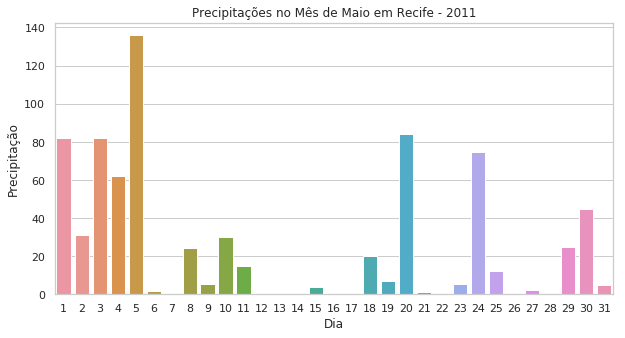

In [54]:
df_month_4_precipitation_2011 = df_day_precipitation_2011[df_day_precipitation_2011['month'] == 5]
sns.set(style="whitegrid")
plt.subplots(figsize=(10,5))
ax = sns.barplot(x="day",y="Precipitacao", data=df_month_4_precipitation_2011)
ax.set(xlabel='Dia', ylabel= u'Precipitação', title=u'Precipitações no Mês de Maio em Recife - 2011')

## Barplot da soma da precipitação mensal em Recife - 2012 

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Meses'),
 Text(0.5, 1.0, 'Precipitação mensal em Recife - 2012')]

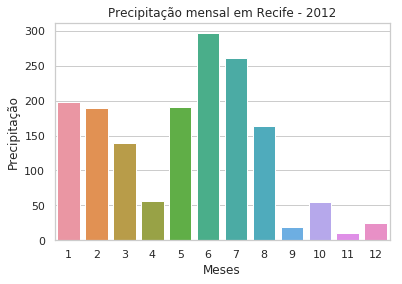

In [58]:
df_month_precipitation_2012 = result_monthly_precipitation_sum[result_monthly_precipitation_sum['year'] == 2012]
df_month_precipitation_2012 = df_month_precipitation_2012[df_month_precipitation_2012['Estacao'] == 'RECIFE']
sns.set(style="whitegrid")
ax = sns.barplot(x="month", y="Precipitacao", data=df_month_precipitation_2012)
ax.set(xlabel='Meses', ylabel= u'Precipitação', title=u'Precipitação mensal em Recife - 2012')

## Boxplot da precipitação diária em Recife - 2012

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Meses'),
 Text(0.5, 1.0, 'Distribuição diária da precipitação em Recife - 2012')]

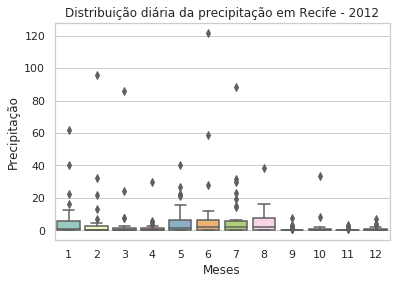

In [59]:
df_day_precipitation_2012 = concat_cities[concat_cities['year'] == 2012]
df_day_precipitation_2012 = df_day_precipitation_2012[df_day_precipitation_2012['Estacao'] == 'RECIFE']
ax = sns.boxplot(x="month", y="Precipitacao", data= df_day_precipitation_2012, palette="Set3")
ax.set(xlabel='Meses', ylabel= u'Precipitação', title=u'Distribuição diária da precipitação em Recife - 2012')

## Boxplot da precipitação no mês de Julho em Recife - 2012

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Dia'),
 Text(0.5, 1.0, 'Precipitações no Mês de Junho em Recife - 2012')]

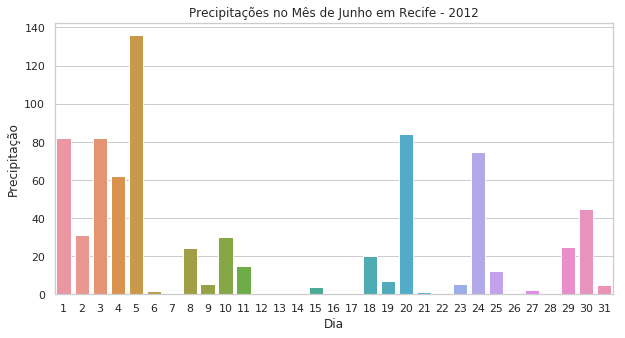

In [60]:
df_month_6_precipitation_2012 = df_day_precipitation_2012[df_day_precipitation_2012['month'] == 6]
sns.set(style="whitegrid")
plt.subplots(figsize=(10,5))
ax = sns.barplot(x="day",y="Precipitacao", data=df_month_4_precipitation_2011)
ax.set(xlabel='Dia', ylabel= u'Precipitação', title=u'Precipitações no Mês de Junho em Recife - 2012')

## Barplot da soma da precipitação mensal em Petrolina - 2009 

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Meses'),
 Text(0.5, 1.0, 'Precipitação mensal em Petrolina - 2009')]

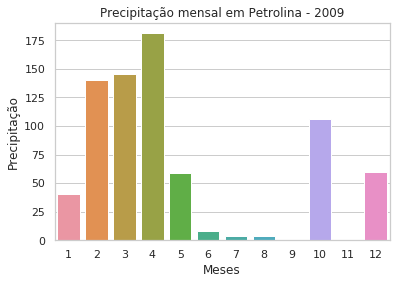

In [62]:
df_month_precipitation_2009 = result_monthly_precipitation_sum[result_monthly_precipitation_sum['year'] == 2009]
df_month_precipitation_2009 = df_month_precipitation_2009[df_month_precipitation_2009['Estacao'] == 'PETROLINA']
sns.set(style="whitegrid")
ax = sns.barplot(x="month", y="Precipitacao", data=df_month_precipitation_2009)
ax.set(xlabel='Meses', ylabel= u'Precipitação', title=u'Precipitação mensal em Petrolina - 2009')

## Boxplot da precipitação diária em Petrolina - 2009 

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Meses'),
 Text(0.5, 1.0, 'Distribuição diária da precipitação em Petrolina - 2009')]

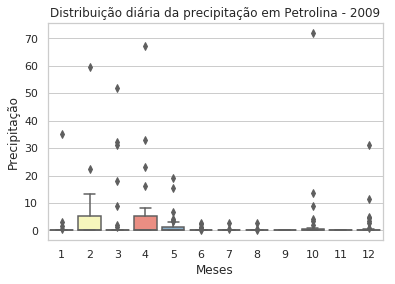

In [63]:
df_day_precipitation_petrolina_2009 = concat_cities[concat_cities['year'] == 2009]
df_day_precipitation_petrolina_2009 = df_day_precipitation_petrolina_2009[df_day_precipitation_petrolina_2009['Estacao'] == 'PETROLINA']
ax = sns.boxplot(x="month", y="Precipitacao", data= df_day_precipitation_petrolina_2009, palette="Set3")
ax.set(xlabel='Meses', ylabel= u'Precipitação', title=u'Distribuição diária da precipitação em Petrolina - 2009')

## Barplot da precipitação diária no Mês de Outubro em Petrolina - 2009

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Dia'),
 Text(0.5, 1.0, 'Precipitações no Mês de Outubro em Petrolina - 2009')]

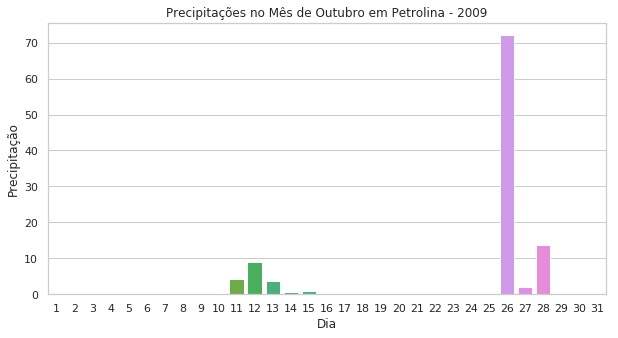

In [64]:
df_day_precipitation_monthy_10_petrolina__2009 = df_day_precipitation_petrolina_2009[df_day_precipitation_petrolina_2009['month'] == 10]
sns.set(style="whitegrid")
plt.subplots(figsize=(10,5))
ax = sns.barplot(x="day",y="Precipitacao", data=df_day_precipitation_monthy_10_petrolina__2009)
ax.set(xlabel='Dia', ylabel= u'Precipitação', title=u'Precipitações no Mês de Outubro em Petrolina - 2009')

## Barplot da precipitação diária no mês de Abril em Petrolina - 2009

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Dia'),
 Text(0.5, 1.0, 'Precipitações no Mês de Abril em Petrolina - 2009')]

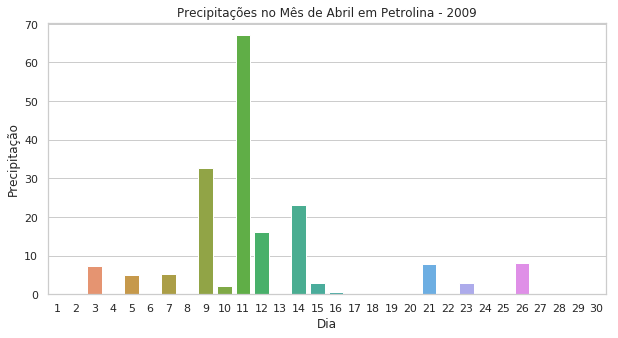

In [65]:
df_day_precipitation_month_4_petrolina_2009 = df_day_precipitation_petrolina_2009[df_day_precipitation_petrolina_2009['month'] == 4]
sns.set(style="whitegrid")
plt.subplots(figsize=(10,5))
ax = sns.barplot(x="day",y="Precipitacao", data=df_day_precipitation_month_4_petrolina_2009)
ax.set(xlabel='Dia', ylabel= u'Precipitação', title=u'Precipitações no Mês de Abril em Petrolina - 2009')

## Barplot da soma da precipitação mensal em Petrolina - 2012

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Meses'),
 Text(0.5, 1.0, 'Precipitação mensal em Petrolina - 2012')]

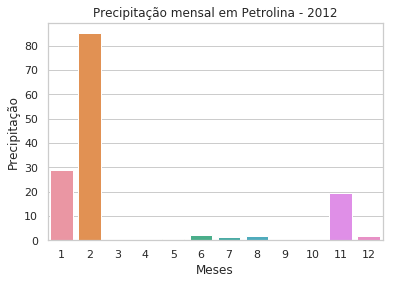

In [66]:
df_month_precipitation_2012 = result_monthly_precipitation_sum[result_monthly_precipitation_sum['year'] == 2012]
df_month_precipitation_2012 = df_month_precipitation_2012[df_month_precipitation_2012['Estacao'] == 'PETROLINA']
sns.set(style="whitegrid")
ax = sns.barplot(x="month", y="Precipitacao", data=df_month_precipitation_2012)
ax.set(xlabel='Meses', ylabel= u'Precipitação', title=u'Precipitação mensal em Petrolina - 2012')

## Boxplot da precipitação mensal em Petrolina - 2012

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Meses'),
 Text(0.5, 1.0, 'Distribuição diária da precipitação em Petrolina - 2012')]

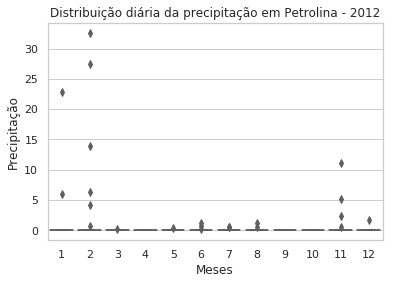

In [67]:
df_day_precipitation_petrolina_2012 = concat_cities[concat_cities['year'] == 2012]
df_day_precipitation_petrolina_2012 = df_day_precipitation_petrolina_2012[df_day_precipitation_petrolina_2012['Estacao'] == 'PETROLINA']
ax = sns.boxplot(x="month", y="Precipitacao", data= df_day_precipitation_petrolina_2012, palette="Set3")
ax.set(xlabel='Meses', ylabel= u'Precipitação', title=u'Distribuição diária da precipitação em Petrolina - 2012')

## Barplot da precipitação diária no mês de Fevereiro em Petrolina - 2012

[Text(0, 0.5, 'Precipitação'),
 Text(0.5, 0, 'Dia'),
 Text(0.5, 1.0, 'Precipitações no Mês de Fevereiro em Petrolina - 2012')]

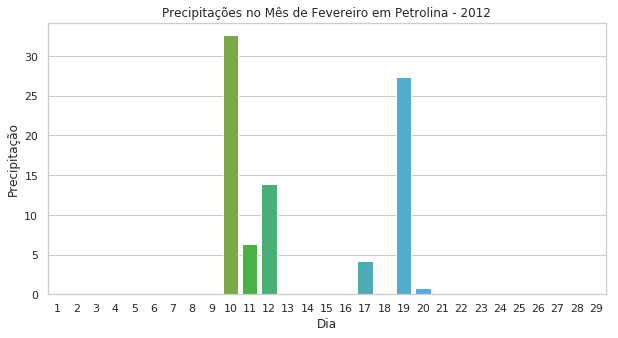

In [68]:
df_day_precipitation_month_2_petrolina_2012 = df_day_precipitation_petrolina_2012[df_day_precipitation_petrolina_2012['month'] == 2]
sns.set(style="whitegrid")
plt.subplots(figsize=(10,5))
ax = sns.barplot(x="day",y="Precipitacao", data=df_day_precipitation_month_2_petrolina_2012)
ax.set(xlabel='Dia', ylabel= u'Precipitação', title=u'Precipitações no Mês de Fevereiro em Petrolina - 2012')